In [1]:
import numpy as np
from keras.layers import Input, Dense, Add, Activation, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model

2024-07-16 09:22:54.319847: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-16 09:22:54.319975: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 09:22:54.445386: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def bottelneck_residual_block(X, kernel_sizes, filters = [], reduce = False, s = 2):
    """Ham khoi tao khoi reisdual, chon reduce hay khong voi 3 khoi conv o mainpath
    X: tensor dau vao
    kernel_sizes: kich thuoc kernel cua lop conv o giua cua mainpath
    filters: mang so nguyen chua so filters cua tung lop conv
    reduce:  True-co them conv o shortcutpath hay khong"""
    
    X_shortcut = X
    F1, F2, F3 = filters
    
    if reduce:
        X_shortcut = Conv2D(filters = F3, kernel_size = (1,1), strides = (s,s))(X_shortcut)
        X_shortcut = BatchNormalization(axis = 3)(X_shortcut)
        
        # ta cau hinh cho strides cua layer dau tien giong voi shortcut path
        X = Conv2D(filters = F1, kernel_size = (1,1), strides = (s,s), padding = 'valid')(X)
        X = BatchNormalization(axis = 3)(X)
        X = Activation('relu')(X)
        
    else:
        X = Conv2D(filters = F1, kernel_size = (1,1), strides = (1,1), padding = 'valid')(X)
        X = BatchNormalization(axis = 3)(X)
        X = Activation('relu')(X)
        
    # thanh phan thu 2 cua mainpath
    X = Conv2D(filters = F2, kernel_size = kernel_sizes, strides = (1,1), padding = 'same')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    # thanh phan thu 3 cua mainpath
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid')(X)
    X = BatchNormalization(axis = 3)(X)
    
    # Cong 2 path
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [3]:
def ResNet50(input_shape, classes):
    """
    Model ResNet50 voi 5 stage gom 50 layer conv"""
    
    X_input = Input(input_shape)
    
    # Stage 1
    X = Conv2D(filters = 64, kernel_size = (7,7), strides = (2,2))(X_input)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3), strides = (2,2))(X)
    
    # Stage 2
    X = bottelneck_residual_block(X, 3, [64, 64, 256], reduce = True, s = 1)
    X = bottelneck_residual_block(X, 3, [64, 64, 256], reduce = False, s = 2)
    X = bottelneck_residual_block(X, 3, [64, 64, 256], reduce = False, s = 2)
    
    # Stage 3
    X = bottelneck_residual_block(X, 3, [128, 128, 512], reduce = True, s = 2)
    X = bottelneck_residual_block(X, 3, [128, 128, 512], reduce = False, s = 2)
    X = bottelneck_residual_block(X, 3, [128, 128, 512], reduce = False, s = 2)
    X = bottelneck_residual_block(X, 3, [128, 128, 512], reduce = False, s = 2)
    
    # Stage 4
    X = bottelneck_residual_block(X, 3, [256, 256, 1024], reduce = True, s = 2)
    X = bottelneck_residual_block(X, 3, [256, 256, 1024], reduce = False, s = 2)
    X = bottelneck_residual_block(X, 3, [256, 256, 1024], reduce = False, s = 2)
    X = bottelneck_residual_block(X, 3, [256, 256, 1024], reduce = False, s = 2)
    X = bottelneck_residual_block(X, 3, [256, 256, 1024], reduce = False, s = 2)
    X = bottelneck_residual_block(X, 3, [256, 256, 1024], reduce = False, s = 2)
    
    # Stage 5
    X = bottelneck_residual_block(X, 3, [512, 512, 2048], reduce = True, s = 2)
    X = bottelneck_residual_block(X, 3, [512, 512, 2048], reduce = False, s = 2)
    X = bottelneck_residual_block(X, 3, [512, 512, 2048], reduce = False, s = 2)
    
    # AVGPool
    X = AveragePooling2D((1,1))(X)
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation = 'softmax')(X)
    
    model = Model(inputs = X_input, outputs = X, name = 'Resnet50')
    
    return model

In [4]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# input image dimension
input_shape = x_train.shape[1: ]

# normalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [5]:
num_classes = 10
data_augumentation = True

In [6]:
from keras.utils import to_categorical

# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [7]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [8]:
from keras.optimizers import Adam

model = ResNet50(input_shape = input_shape, classes = 10)

model.compile(loss = 'categorical_crossentropy',
             optimizer = Adam(learning_rate = lr_schedule(0)),
             metrics = ['accuracy'])

model.summary()

Learning rate:  0.001


Model: "Resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 13, 13,    │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 13, 13,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 13, 13,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 6, 6, 64)  │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 6, 6, 64)  │      4,160 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 6, 64)  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 6, 6, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 6, 6, 64)  │     36,928 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 6, 64)  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 6, 6, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 6, 6, 256) │     16,640 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 6, 6, 256) │     16,640 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 6, 256) │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 6, 256) │      1,024 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 6, 6, 256) │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 6, 6, 256) │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 6, 6, 64)  │     16,448 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 23,555,082 (89.86 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [9]:
import os

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_ResNet50_model.{epoch:03d}.weights.h5' 
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [10]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import Callback, ReduceLROnPlateau

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                            save_weights_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [11]:
data_augmentation = False
epochs = 200
batch_size = 32

In [12]:
# Define a callback to track loss
class LossHistory(Callback):
    def __init__(self):
        self.losses = []

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs['loss'])

history = LossHistory()

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=[history])
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
#         zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None)
        # fraction of images reserved for validation (strictly between 0 and 1)
#         validation_split=0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1,
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        callbacks=callbacks)

Not using data augmentation.
Epoch 1/200
   3/1563 ━━━━━━━━━━━━━━━━━━━━ 53s 35ms/step - accuracy: 0.1076 - loss: 4.3231    

I0000 00:00:1721121862.358945      67 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721121862.440752      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2888 - loss: 2.3873

W0000 00:00:1721121937.757429      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 137s 51ms/step - accuracy: 0.2889 - loss: 2.3872 - val_accuracy: 0.1804 - val_loss: 7.7129
Epoch 2/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - accuracy: 0.3595 - loss: 2.0798 - val_accuracy: 0.3587 - val_loss: 1.8302
Epoch 3/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - accuracy: 0.4186 - loss: 1.8552 - val_accuracy: 0.4601 - val_loss: 2.8882
Epoch 4/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 48s 31ms/step - accuracy: 0.4506 - loss: 1.7788 - val_accuracy: 0.2826 - val_loss: 2.6764
Epoch 5/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.4889 - loss: 1.5568 - val_accuracy: 0.2460 - val_loss: 2.3117
Epoch 6/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.4550 - loss: 1.7352 - val_accuracy: 0.5145 - val_loss: 2.5254
Epoch 7/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.5458 - loss: 1.3960 - val_accuracy: 0.4136 - val_loss: 2.9853
Epoch 8/200
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.5089 - lo

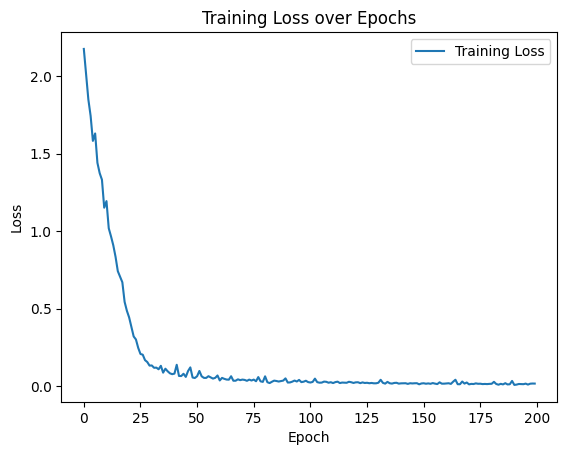

In [14]:
import matplotlib.pyplot as plt

# Plot the training loss
plt.figure()
plt.plot(history.losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from sklearn.metrics import classification_report
import tensorflow as tf

# Evaluate model and generate F1-score report
correct = 0
total = 0

all_labels = []
all_predictions = []


# Assuming model is your Keras model and x_test, y_test are your test data
with tf.device('/GPU:0'):  # Specify GPU if available
    predictions = model.predict(x_test)  # Predict using the test data

    all_predictions = np.argmax(predictions, axis=1)
    all_labels = np.argmax(y_test, axis=1)  # Assuming y_test is one-hot encoded

accuracy = np.sum(all_predictions == all_labels) / len(all_labels) * 100

# Generate F1-score report
report = classification_report(all_labels, all_predictions, target_names=['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

print('Accuracy on test set: {:.2f}%'.format(accuracy))
print('F1-Score Report:\n', report)


313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step
Accuracy on test set: 74.94%
F1-Score Report:
               precision    recall  f1-score   support

       plane       0.81      0.77      0.79      1000
         car       0.83      0.86      0.84      1000
        bird       0.65      0.71      0.68      1000
         cat       0.57      0.58      0.58      1000
        deer       0.71      0.71      0.71      1000
         dog       0.66      0.64      0.65      1000
        frog       0.74      0.85      0.79      1000
       horse       0.82      0.76      0.79      1000
        ship       0.85      0.86      0.86      1000
       truck       0.87      0.75      0.81      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

